In [ ]:
# Telecoms Churn Prediction
# Data : https://mapr.com/blog/churn-prediction-pyspark-using-mllib-and-ml-packages/

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer,IndexToString,VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Building the Spark Session
# Befire 2.0.0, the main connection objects were 'SaprkContext,SqlContext, and HiveContext'

spark = SparkSession \
        .builder \
        .appName("Churn_pred_ML") \
        .config('spark.some.config.option','some-value') \
        .getOrCreate()

# here, 'spark' is an object of SparkSession, which has the 'SparkContext' object and can be accessed directly
sc = spark.sparkContext
print(sc.version)

2.0.2


In [3]:
train_data = spark.read \
    .format('com.databricks.spark.csv') \
    .option('header','true') \
    .option('inferSchema', 'true') \
    .load('/home/ramscrux7757/SPARK/Churn_pred/churn-bigml-80.csv')
    
test_data = spark.read \
    .format('com.databricks.spark.csv') \
    .option('header','true') \
    .option('inferSchema', 'true') \
    .load('/home/ramscrux7757/SPARK/Churn_pred/churn-bigml-20.csv')

train_data.cache()
train_data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [14]:
# converting the 'boolean' type into 'String' type
train_data = train_data.withColumn("Churn", train_data["Churn"].cast('string'))
test_data = test_data.withColumn("Churn", test_data["Churn"].cast('string'))

In [15]:
train_data.printSchema()

root
 |-- Account length: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: string (nullable = true)



In [5]:
print(train_data.count(), len(train_data.columns))
print(test_data.count(), len(test_data.columns))

(2666, 20)
(667, 20)


In [6]:
pd.set_option('display.max_columns', 50)
pd.DataFrame(train_data.take(5), columns=train_data.columns)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [16]:
# Dropping State and Area code features (both from train and test datasets)

train_data = train_data.drop('State').drop('Area Code')
test_data = test_data.drop('State').drop('Area Code')

print(train_data.count(), len(train_data.columns))
print(test_data.count(), len(test_data.columns))

(2666, 18)
(667, 18)


In [8]:
train_data.describe().toPandas()

,summary,Account length,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,count,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666,2666
1,mean,100.62040510127532,8.021755438859715,179.48162040510135,100.31020255063765,30.512404351087813,200.38615903976006,100.02363090772693,17.033072018004518,201.16894223555968,100.10615153788447,9.052689422355604,10.23702175543886,4.467366841710428,2.764489872468112,1.5626406601650413
2,stddev,39.56397365334985,13.61227701829193,54.21035022086982,19.988162186059512,9.215732907163497,50.95151511764598,20.16144511531889,4.330864176799864,50.780323368725206,19.418458551101697,2.2851195129157564,2.7883485770512566,2.4561949030129466,0.7528120531228477,1.3112357589949093
3,min,1,0,0.0,0,0.0,0.0,0,0.0,43.7,33,1.97,0.0,0,0.0,0
4,max,243,50,350.8,160,59.64,363.7,170,30.91,395.0,166,17.77,20.0,20,5.4,9


In [17]:
# separating the numerical and categorical features
train_num_feat = [feat[0] for feat in train_data.dtypes if feat[1] == 'int' or feat[1] == 'double']
test_num_feat = [feat[0] for feat in test_data.dtypes if feat[1] == 'int' or feat[1] == 'double']

train_cat_feat = [feat[0] for feat in train_data.dtypes if feat[1] == 'string']
test_cat_feat = [feat[0] for feat in test_data.dtypes if feat[1] == 'string']

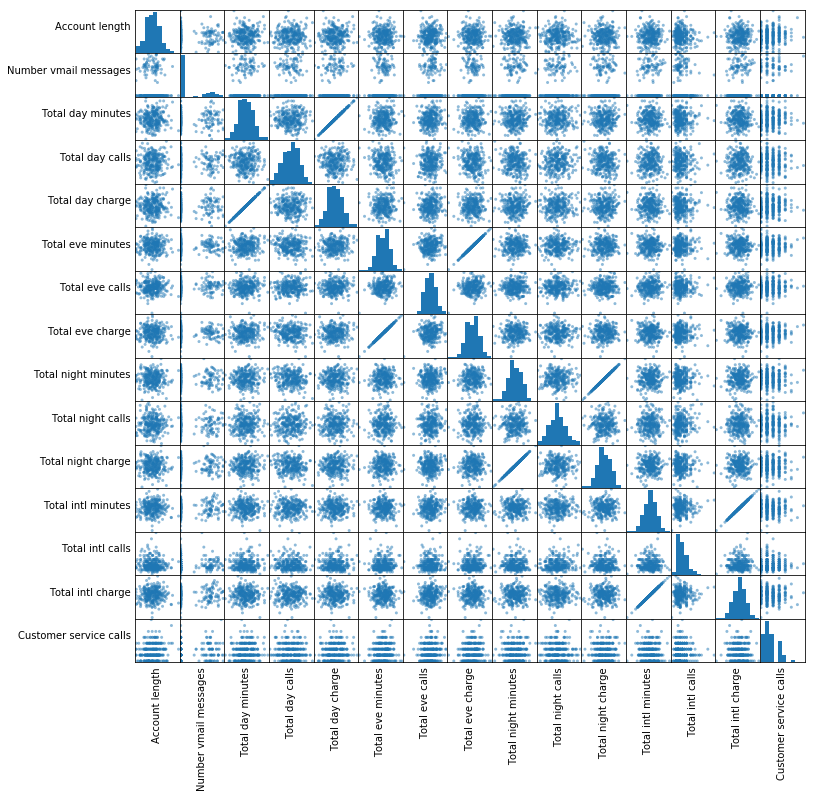

In [10]:
# taking a sample from train_data to check the correlations

train_samp_data = train_data.select(train_num_feat).sample(False, 0.10, 101).toPandas()

axs = pd.plotting.scatter_matrix(train_samp_data, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(train_samp_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [ ]:
# correlated features:
# 1. Total day minuites and Total day charge
# 2. Total eve minuites and Total eve charge
# 3. Total night minuites and Total night charge
# 4. Total intl minuites and Total intl charge

In [18]:
# Dropping the correlated columns from the above list
cols_to_drop = ['Total day charge','Total eve charge','Total night charge','Total intl charge']

train_data_mod = train_data.select([col for col in train_data.columns if col not in cols_to_drop])
test_data_mod = test_data.select([col for col in test_data.columns if col not in cols_to_drop])

#train_data = train_data.drop('Total day charge').drop('Total eve charge') \
#            .drop('Total night charge').drop('Total intl charge')
    
print(train_data_mod.count(), len(train_data_mod.columns))
print(test_data_mod.count(), len(test_data_mod.columns))

(2666, 14)
(667, 14)


In [19]:
train_cat_feat

['International plan', 'Voice mail plan', 'Churn']

In [20]:
# Removing the target variable 'Churn' from preprocessing steps
train_cat_feat.remove('Churn')
print(train_cat_feat)

['International plan', 'Voice mail plan']


In [21]:
train_data_mod.groupBy('International plan').count().show()

+------------------+-----+
|International plan|count|
+------------------+-----+
|                No| 2396|
|               Yes|  270|
+------------------+-----+



In [22]:
train_data_mod.groupBy('Voice mail plan').count().show()

+---------------+-----+
|Voice mail plan|count|
+---------------+-----+
|             No| 1933|
|            Yes|  733|
+---------------+-----+



In [23]:
train_data_mod.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|false| 2278|
| true|  388|
+-----+-----+



In [25]:
# Lable encoding of categorical variables
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

stringindexer_stages = [StringIndexer(inputCol=col, outputCol=col+'_idx') for col in train_cat_feat]
onehotencoder_stages = [OneHotEncoder(inputCol=col+'_idx', outputCol=col+'_hot_enc') for col in train_cat_feat]
all_stages = stringindexer_stages + onehotencoder_stages

# build pipeline model
pipeline = Pipeline(stages=all_stages)

# fit pipeline model
train_pipeline_mode = pipeline.fit(train_data_mod)
test_pipeline_mode  = pipeline.fit(test_data_mod)

# transform data
train_encoded = train_pipeline_mode.transform(train_data_mod)
test_encoded = test_pipeline_mode.transform(test_data_mod)

# dropping the unwanted columns

cols_to_drop_enc = ['International plan','Voice mail plan','International plan_idx','Voice mail plan_idx']

train_encoded = train_encoded.select([col for col in train_encoded.columns if col not in cols_to_drop_enc])
test_encoded = test_encoded.select([col for col in test_encoded.columns if col not in cols_to_drop_enc])

train_encoded.toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,2641,2642,2643,2644,2645,2646,2647,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657,2658,2659,2660,2661,2662,2663,2664,2665
Account length,128,107,137,84,75,118,121,147,141,74,168,95,62,85,93,76,73,147,77,130,132,174,57,54,20,...,71,58,172,45,100,94,128,181,127,89,149,103,163,52,89,122,62,117,78,96,79,192,68,28,74
Number vmail messages,25,26,0,0,0,0,24,0,37,0,0,0,0,27,0,33,0,0,0,0,0,0,39,0,0,...,0,22,0,0,0,0,0,0,0,0,18,29,0,0,0,0,0,0,0,0,0,36,0,0,25
Total day minutes,265.1,161.6,243.4,299.4,166.7,223.4,218.2,157,258.6,187.7,128.8,156.6,120.7,196.4,190.7,189.7,224.4,155.1,62.4,183,81.1,124.3,213,134.3,190,...,186.1,224.1,203.9,211.3,219.4,190.4,147.7,229.9,102.8,178.7,148.5,164.1,197.2,124.9,115.4,140,321.1,118.4,193.4,106.6,134.7,156.2,231.1,180.8,234.4
Total day calls,110,123,114,71,113,98,88,79,84,127,96,88,70,139,114,66,90,117,89,112,86,76,115,73,109,...,114,127,109,87,112,91,94,130,128,81,106,111,90,131,99,101,105,126,99,128,98,77,57,109,113
Total eve minutes,197.4,195.5,121.2,61.9,148.3,220.6,348.5,103.1,222,163.4,104.9,247.6,307.2,280.9,218.2,212.8,159.5,239.7,169.9,72.9,245.2,277.1,191.1,155.5,258.2,...,198.6,238.8,234,165.7,225.7,92,283.3,144.4,143.7,233.7,114.5,219.1,188.5,300.5,209.9,196.4,265.5,249.3,116.9,284.8,189.7,215.5,153.4,288.8,265.9
Total eve calls,99,103,110,88,122,101,108,94,111,148,71,75,76,90,111,65,88,93,121,99,72,112,112,100,84,...,140,85,123,97,102,107,83,93,95,74,106,96,113,118,115,77,122,97,88,87,68,126,55,58,82
Total night minutes,244.7,254.4,162.6,196.9,186.9,203.9,212.6,211.8,326.4,196,141.1,192.3,203,89.3,129.6,165.7,192.8,208.8,209.6,181.8,237,250.7,182.7,102.1,181.5,...,206.5,174.2,160.7,265.9,255.3,224.8,188.3,262.4,191.4,131.9,178.3,220.3,211.1,192.5,280.9,120.1,180.5,227,243.3,178.9,221.4,279.1,191.3,191.9,241.4
Total night calls,91,103,104,89,121,118,118,96,97,94,128,115,99,75,121,108,74,133,64,78,115,115,115,68,102,...,80,86,65,72,95,108,124,110,97,120,98,108,94,106,112,133,72,56,109,92,128,83,123,91,77
Total intl minutes,10,13.7,12.2,6.6,10.1,6.3,7.5,7.1,11.2,9.1,11.2,12.3,13.1,13.8,8.1,10,13,10.6,5.7,9.5,10.3,15.5,9.5,14.7,6.3,...,13.8,11.5,17.8,13.3,12,13.6,6.9,14.2,10,9.1,6.5,12.3,7.8,11.6,15.9,9.7,11.5,13.6,9.3,14.9,11.8,9.9,9.6,14.1,13.7
Total intl calls,3,3,5,7,3,6,7,6,5,5,2,5,6,4,3,5,2,4,6,19,2,5,3,4,6,...,5,7,4,6,4,17,5,4,5,4,4,9,8,4,6,4,2,3,4,7,5,6,4,6,4


In [26]:
#train_encoded.select('International plan_hot_enc').show()
train_encoded.select('Voice mail plan_hot_enc').show()

+-----------------------+
|Voice mail plan_hot_enc|
+-----------------------+
|              (1,[],[])|
|              (1,[],[])|
|          (1,[0],[1.0])|
|          (1,[0],[1.0])|
|          (1,[0],[1.0])|
|          (1,[0],[1.0])|
|              (1,[],[])|
|          (1,[0],[1.0])|
|              (1,[],[])|
|          (1,[0],[1.0])|
|          (1,[0],[1.0])|
|          (1,[0],[1.0])|
|          (1,[0],[1.0])|
|              (1,[],[])|
|          (1,[0],[1.0])|
|              (1,[],[])|
|          (1,[0],[1.0])|
|          (1,[0],[1.0])|
|          (1,[0],[1.0])|
|          (1,[0],[1.0])|
+-----------------------+
only showing top 20 rows



# Modeling part

In [27]:
train_fea = train_encoded.columns
train_fea.remove('Churn')
train_fea

['Account length',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total eve minutes',
 'Total eve calls',
 'Total night minutes',
 'Total night calls',
 'Total intl minutes',
 'Total intl calls',
 'Customer service calls',
 'International plan_hot_enc',
 'Voice mail plan_hot_enc']

In [28]:
# Spark ML specific Transformations
# The following will add two columns to the dataset ('features (a vector of all predictors) and Labeled categorical column)
# The ml algorithm can straightaway take these two columns 

# Prepare the data by indexing the classes and putting the features into a vector.
speciesIndexer = StringIndexer(inputCol="Churn", outputCol="Label")
vectorAssembler = VectorAssembler(inputCols=train_fea,outputCol="features")

pred_vector = vectorAssembler.transform(train_encoded) # it collects the predictor variable names
index_model = speciesIndexer.fit(pred_vector) # about the target variable
train_data_indexed = index_model.transform(pred_vector) # creates the 'features' and 'Labels' 
# ('features' and 'Labels' will be feeded into the model straightaway)

pred_vector_test = vectorAssembler.transform(test_encoded) # it collects the predictor variable names
index_model_test = speciesIndexer.fit(pred_vector_test) # about the target variable
test_data_indexed = index_model_test.transform(pred_vector_test) # creates the 'features' and 'Labels' 
# ('features' and 'Labels' will be feeded into the model straightaway)

print(train_data_indexed.limit(5)).toPandas()

   Account length  Number vmail messages  Total day minutes  Total day calls  \
0             128                     25              265.1              110   
1             107                     26              161.6              123   
2             137                      0              243.4              114   
3              84                      0              299.4               71   
4              75                      0              166.7              113   

   Total eve minutes  Total eve calls  Total night minutes  Total night calls  \
0              197.4               99                244.7                 91   
1              195.5              103                254.4                103   
2              121.2              110                162.6                104   
3               61.9               88                196.9                 89   
4              148.3              122                186.9                121   

   Total intl minutes  Total int

In [48]:
# Training and Testing a Classification Model

# Split the data into training and test sets.
train, test =  train_data_indexed.randomSplit([0.7, 0.3],101) # seed=123

# Configure the classifier and then train it using the training set.
rf = RandomForestClassifier(labelCol='Label', featuresCol='features',numTrees=100, maxDepth=4,maxBins=32)
model_rf = rf.fit(train)

In [30]:
pd.DataFrame(train.take(2), columns=train.columns)

,Account length,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn,International plan_hot_enc,Voice mail plan_hot_enc,features,Label
0,1,0,123.8,113,236.2,77,73.2,81,3.7,2,0,false,(1.0),(1.0),"[1.0, 0.0, 123.8, 113.0, 236.2, 77.0, 73.2, 81...",0.0
1,1,0,182.1,106,134.9,106,152.3,75,10.0,3,5,true,(1.0),(1.0),"[1.0, 0.0, 182.1, 106.0, 134.9, 106.0, 152.3, ...",1.0


In [49]:
# Run the classifier on the test set
from pyspark.ml.feature import StringIndexer,IndexToString
predictions = model_rf.transform(test)

# here the 'predictions' will contain all the variables + features + Label + rawPrediction + probability + prediction

# Un-index the data so we have the species names rather than the index numbers in our output.
converter = IndexToString(inputCol="prediction", outputCol="PredictedLabels", labels=index_model.labels)
converted = converter.transform(predictions)

# here 'converted' contains all from above 'predictions' + PredictedLabels' 

# Display the actual and predicted species side-by-side
converted.select(['Churn','Label','prediction','PredictedLabels']).show(10) 
# original, original_indexed, predicted_indexed and predicted_decoded
#converted.select(['PredictedLabels']).show(10)

+-----+-----+----------+---------------+
|Churn|Label|prediction|PredictedLabels|
+-----+-----+----------+---------------+
| true|  1.0|       1.0|           true|
|false|  0.0|       0.0|          false|
|false|  0.0|       0.0|          false|
|false|  0.0|       0.0|          false|
|false|  0.0|       0.0|          false|
|false|  0.0|       0.0|          false|
|false|  0.0|       0.0|          false|
|false|  0.0|       0.0|          false|
|false|  0.0|       0.0|          false|
|false|  0.0|       0.0|          false|
+-----+-----+----------+---------------+
only showing top 10 rows



In [45]:
# Model Evaluation
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction",
                                              metricName="f1") #or 'accuracy'

#evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction",
#                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.898831439823


In [50]:
# Predictions on the original test data
#from pyspark.ml.feature import StringIndexer,IndexToString
predictions = model_rf.transform(test_data_indexed)

# Un-index the data so we have the species names rather than the index numbers in our output.
converter = IndexToString(inputCol="prediction", outputCol="PredictedLabels", labels=index_model.labels)
converted = converter.transform(predictions)

converted.select(['Churn','Label','prediction','PredictedLabels']).show(10) 

+-----+-----+----------+---------------+
|Churn|Label|prediction|PredictedLabels|
+-----+-----+----------+---------------+
|false|  0.0|       0.0|          false|
| true|  1.0|       0.0|          false|
| true|  1.0|       0.0|          false|
|false|  0.0|       0.0|          false|
|false|  0.0|       0.0|          false|
|false|  0.0|       0.0|          false|
|false|  0.0|       0.0|          false|
| true|  1.0|       0.0|          false|
|false|  0.0|       0.0|          false|
|false|  0.0|       0.0|          false|
+-----+-----+----------+---------------+
only showing top 10 rows



In [62]:
# Evaluation on the original test data (since the labels are available !!!)

accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.892452427545
